In [1]:
import os
import sys

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    classification_report,
)

# Local module imports
sys.path.insert(0, "..") # adds parent folder to sys path
from models.chatbot_model_imdb import ChatbotModelImdb

In [2]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data["Sentence"] = data["Sentence"].str.lower()
    data["Sentence"] = data["Sentence"].replace(
        "[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+", "", regex=True
    )  # remove emails
    data["Sentence"] = data["Sentence"].replace(
        "((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}", "", regex=True
    )  # remove IP address
    data["Sentence"] = data["Sentence"].str.replace(
        "[^\w\s]", ""
    )  # remove special characters
    data["Sentence"] = data["Sentence"].replace("\d", "", regex=True)  # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row["Sentence"])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words("english")]
        print(f"\r{index}", end="")
        df_ = df_.append(
            {
                "index": row["index"],
                "Class": row["Class"],
                "Sentence": " ".join(filtered_sent[0:]),
            },
            ignore_index=True,
        )
    return data

In [3]:
classes = {"positive": 1, "negative": 0}

In [4]:
DATASET_PATH = "../datasets/imdb-reviews/"
TEST_DATA_PATH = DATASET_PATH + "Test.csv"
TRAIN_DATA_PATH = DATASET_PATH + "Train.csv"
VALID_DATA_PATH = DATASET_PATH + "Valid.csv"

TEST_SIZE = 1000
VALID_SIZE = 500
TRAIN_SIZE = 9000

columns = ["index", "Class", "Sentence"]

test_data = pd.read_csv(TEST_DATA_PATH, nrows=TEST_SIZE, delimiter=',', header=None, quotechar='"')
test_data.columns = ["Sentence", "Class"]
test_data["index"] = test_data.index
test_data = preprocess_pandas(test_data, columns)

print("1")

valid_data = pd.read_csv(VALID_DATA_PATH, nrows=VALID_SIZE, delimiter=',', header=None, quotechar='"')
valid_data.columns = ["Sentence", "Class"]
valid_data["index"] = valid_data.index
valid_data = preprocess_pandas(valid_data, columns)

print("2")

train_data = pd.read_csv(TRAIN_DATA_PATH, nrows=TRAIN_SIZE, delimiter=',', header=None, quotechar='"')
train_data.columns = ["Sentence", "Class"]
train_data["index"] = train_data.index
train_data = preprocess_pandas(train_data, columns)

print("3")


print(len(test_data))
print(test_data)
print(len(valid_data))
print(valid_data)
print(len(train_data))
print(train_data)

9991
4992
89993
1000
                                              Sentence  Class  index
0    i always wrote this series off as being a comp...      0      0
1    st watched    out of dirsteve purcell typical ...      0      1
2    this movie was so poorly written and directed ...      0      2
3    the most interesting thing about miryang secre...      1      3
4    when i first read about berlin am meer i didnt...      0      4
..                                                 ...    ...    ...
995  this movie is truly amazingover the years i ha...      0    995
996  the underground comedy movie is possibly the w...      0    996
997  this production was quite a surprise for me i ...      1    997
998  sorry but i usually love french thrillers  eg ...      0    998
999  thankfully brief mystery about a telephone ope...      0    999

[1000 rows x 3 columns]
500
                                              Sentence  Class  index
0    its been about  years since sharon stone award..

In [5]:
# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    max_features=50000,
    max_df=0.5,
    use_idf=True,
    norm="l2",
)

testing_data = test_data["Sentence"].values.astype("U")
testing_labels = test_data["Class"].values.astype("int32")

training_data = train_data["Sentence"].values.astype("U")
training_labels = train_data["Class"].values.astype("int32")

validation_data = valid_data["Sentence"].values.astype("U")
validation_labels = valid_data["Class"].values.astype("int32")

training_data = word_vectorizer.fit_transform(training_data)  # transform texts to sparse matrix
training_data = training_data.todense()  # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)

validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()

testing_data = word_vectorizer.transform(testing_data)
testing_data = testing_data.todense()

train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()

validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

test_x_tensor = torch.from_numpy(np.array(testing_data)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(testing_labels)).long()

In [6]:
# Combine data with labels
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
validation_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

trainloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
validationloader = DataLoader(validation_dataset, batch_size=len(validation_data), shuffle=False)
testloader = DataLoader(test_dataset, batch_size=len(test_data), shuffle=False)

print(f"Training size={len(train_dataset)}")
print(f"Validation size={len(validation_dataset)}")
print(f"Test size={len(test_dataset)}")

Training size=9000
Validation size=500
Test size=1000


Epoch 10 [90/90] - Loss: 0.019441159442067146

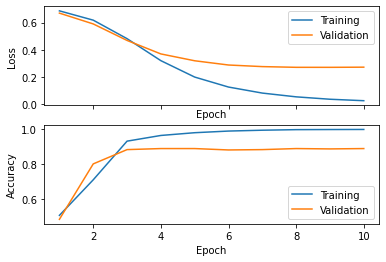

In [7]:
# Use the model defined in ./models/chatbot_model.py
network = ChatbotModelImdb(vocab_size=vocab_size, vectorizer=word_vectorizer)

optimizer = torch.optim.Adam(network.parameters(), lr=0.0001, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss()

epochs = 10

validation_loss = []
training_loss = []

training_accuracy = []
validation_accuracy = []

for epoch in range(epochs):
    validation_loss_epoch = 0
    training_loss_epoch = 0
    training_batches = 0
    validation_batches = 0
    
    training_correct_epoch = 0
    training_total_epoch = 0
    validation_correct_epoch = 0
    validation_total_epoch = 0
    
    for batch_nr, (data, labels) in enumerate(trainloader):
        training_batches += 1
        prediction = network(data)
        loss = loss_function(prediction, labels)
        
        training_loss_epoch += loss.item()
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        # Collect training accuracy statistics
        prediction = list(pred.argmax() for pred in prediction)
        training_correct_epoch += np.equal(prediction, labels).sum().item()
        training_total_epoch += len(labels)
        
        #Print the epoch, batch, and loss
        print(
            f'\rEpoch {epoch+1} [{batch_nr+1}/{len(trainloader)}] - Loss: {loss}',
            end=''
        )
        
    for batch_nr, (data, labels) in enumerate(validationloader):
        with torch.no_grad():
            validation_batches += 1
            prediction = network(data)
            loss = loss_function(prediction, labels)
            validation_loss_epoch += loss.item()
            
            # Collect validation accruacy statistics
            prediction = list(pred.argmax() for pred in prediction)
            validation_correct_epoch += np.equal(prediction, labels).sum().item()
            validation_total_epoch += len(labels)
        
    # Store loss for plot
    avr_training_loss = training_loss_epoch/training_batches
    avr_validation_loss = validation_loss_epoch/validation_batches
    training_loss.append(avr_training_loss)
    validation_loss.append(avr_validation_loss)
    
    # Store accuracy for plot
    training_accuracy.append(training_correct_epoch / training_total_epoch)
    validation_accuracy.append(validation_correct_epoch / validation_total_epoch)


fig, (plt_loss, plt_accuracy) = plt.subplots(2, sharex=True)
plt_loss.plot(range(1, len(training_loss)+1), training_loss, label="Training")
plt_loss.plot(range(1, len(validation_loss)+1), validation_loss, label="Validation")
plt_loss.set_xlabel('Epoch')
plt_loss.set_ylabel('Loss')
plt_loss.legend()

plt_accuracy.plot(range(1, len(training_accuracy)+1), training_accuracy, label="Training")
plt_accuracy.plot(range(1, len(validation_accuracy)+1), validation_accuracy, label="Validation")
plt_accuracy.set_xlabel('Epoch')
plt_accuracy.set_ylabel('Accuracy')
plt_accuracy.legend()

In [8]:
correct = 0
total = 0

# Test accuracy
for batch_nr, (data, labels) in enumerate(testloader):
    predictions = network.predict(data)

    # Sum all the predictions that were the same as the label
    correct += np.equal(predictions, labels).sum().item()
    total += len(labels)

print(f'The accuracy of the network on the test data is {str(100*correct/total)[:4]}%. total={total} correct={correct}')

The accuracy of the network on the test data is 89.8%. total=1000 correct=898


In [9]:
# Let's print a sentence and predict it's category
str_input = "i very much like it"
#str_input = "I really enjoyed watching this one. The family romance, the jokes, and the story, all works for me. The plot is good, all matches, quite makes sense. The most if it is the ending, very nice to close the film. Of course you can't demand too much logic for this film as it is a sort of fantasy film along side with maybe sci fi. Yes it is an easy-watching film, not a heavy one. But for a type of an easy-watching film, for me it is a masterpiece, very enjoyable."
#str_input = "Drax comedy is still my favourite, Peter having sexual emotion for Gamora and Drax screaming top of his lungs cracked me the most. Drax and Mentis just starting their weird relation."
#str_input = "One is almost loath to point a finger at suspension of disbelief when it comes to a movie whose premise is sharks in tornadoes, but whatever level you plan to come in with is almost surely going to fall far short. This movie has more WTF moments in 86 minutes than Lost could pull off in 86 seasons. And everyone gets to play, not just those with a working knowledge of wind shear or the physics that keep a helicopter in the air. If you've played pool, fished, surfed, driven a car in water deeper than two inches, been exposed to gravity, or otherwise in any way have interacted with or gained some understanding of the world around you, this movie has something for you to go 'wha!?!' about.And while you would think that once you had bad special effects, bad editing, and bad sound strung together you'd get at least one Bruce Campbell out of the cast to latch on to. Not so here, as every actor turned in a performance that shows they were more confused than the viewer about what was happening. We could guess it was because they were given the script out of order, but as a viewer of the final product I'm not sure I've seen the scenes in order, they are that disjointed.I've tried very hard to find something that was done well or noteworthy about this movie and the only thing I can come up with is that it is the only movie I have ever seen that has failed on absolutely every level. If you tried to make a movie this bad you would inadvertently get something right purely on accident. And that is its one bright, shining point of light. That it would be almost impossible to make something this terrible ever again."
#str_input = "You have probably seen a whole bunch of reviews saying that it's so bad it's good. Well it's so bad it's worse than bad. Do not waste your time with this movie. There is no continuity between scenes, one second it's flooding then in the next scene the streets are dry. The acting is terrible, the special effects are less than special.Lastly, poor Tara, she had some good movies under her belt, but this is the latest in a downward spiral for her acting career. It seems like she has been taking acting lessons from the rest of the cast because her performance is no better than the rest. Please watch something else. I beg you."
prediction = network.predict_str(str_input)
#print(classes)
#print(prediction)
prediction = "positive" if prediction == classes["positive"] else "negative"
print(f"The input '{str_input}' is {prediction}")

The input 'i very much like it' is positive
